# Week 25 | 18th June - 24th June 2018

In [1]:
#packages
import pandas as pd
import csv
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import glob
import pycountry
from datetime import datetime

#chaning the number of columns that are displayed. get will tell you how much. 
pd.set_option("display.max_columns",50)
sns.set_style("whitegrid")

#currency converter
from currency_converter import CurrencyConverter
c = CurrencyConverter('http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip')

pd.options.mode.chained_assignment = None

# 1. Performance per Country

In [2]:
### Cleaning

#importing Data
df_campaign=pd.read_excel("25_campaign.xlsx")

#dropping unused columns
df_campaign.drop(columns=["id","status","Rejection rate","url","client_id","ap_campaign_id",
                          "ad_set_campaign_group_id","notification_stop_spend_threshold","margin_percentage",
                          "facebook_business_id","contract_range","salesforce_oppurtunity_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_campaign["marginP"] = df_campaign.apply(woo, axis=1)
df_campaign["marginP"] = df_campaign["marginP"].round(2)

#2. COUNTRY NAMES
df_campaign["country"]=df_campaign["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_campaign["country"] = df_campaign["country"].apply(get_country_code)
df_campaign.drop(columns=["iso_code"], inplace=True)

### 1.1 Average Margin % per country

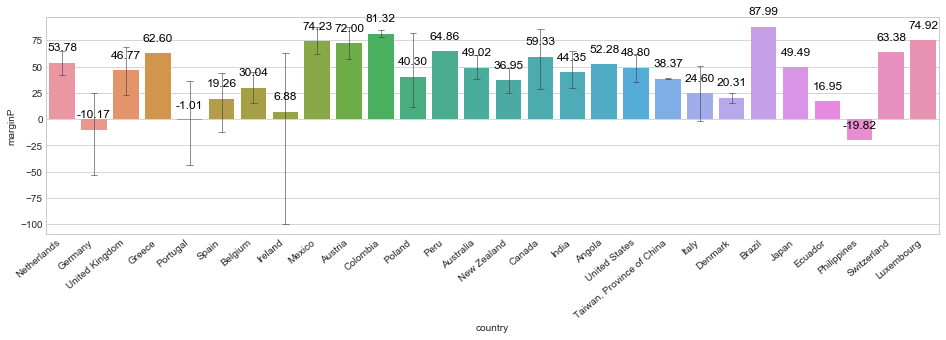

In [3]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

In [4]:
def converter(x):
    if x["business_name"] == "Toronto":
        return(c.convert(x["margin"], "CAD", "EUR"))
    if x["business_name"] == "Melbourne":
        return(c.convert(x["margin"], "AUD", "EUR"))
    if x["business_name"] == "London":
        return(c.convert(x["margin"], "GBP", "EUR"))
    else:
        return(x["margin"])

df_campaign=df_campaign.assign(**{"converted": df_campaign.apply(converter, axis=1)})

df_campaign["converted"]=df_campaign["converted"].round(2)

In [5]:
#total by country
df_campaign['total']=1
df_country=df_campaign.groupby(by=['country']).sum()
df_country["margin_%"]=(df_country["margin"]/df_country["revenue"])*100
df_country["margin_%"]=df_country["margin_%"].round(2)
df_country["country"]=df_country.index

### 1.2 Total Margin % per country

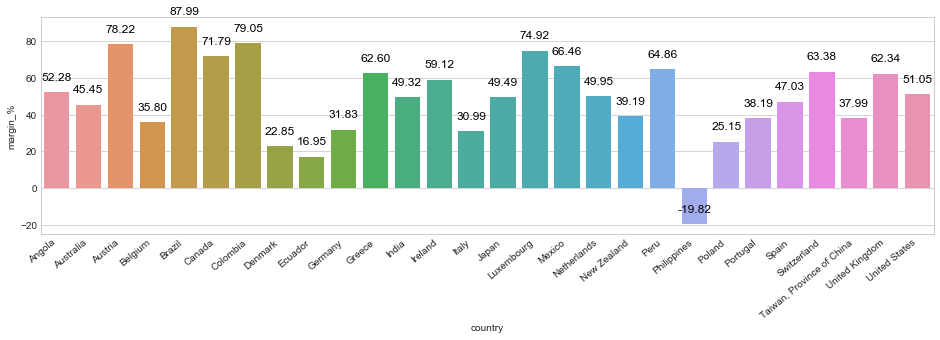

In [6]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="margin_%", data=df_country, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 1.3 Margin across countries in native currency

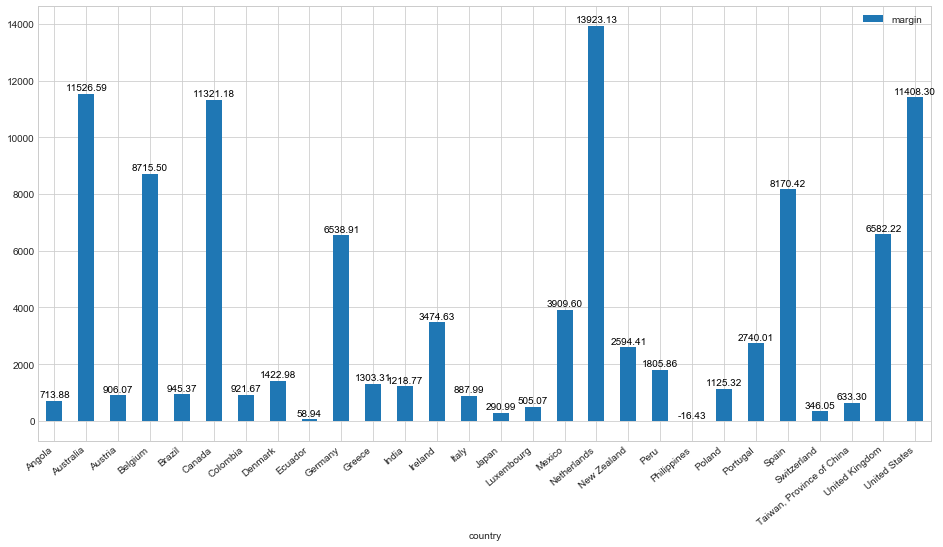

In [7]:
pa=df_country[["margin"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=10, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 1.4 Margins in Euro

#### *This currecy conversion should be updated relatively regularly. I have tested it a few times and it is very accurite with smaller amounts and within €5 (+/-) for larger amounts (e.g. 2606.53 CAD was converted to 1701.50 EUR, when it should be 1,696.17 EUR)*

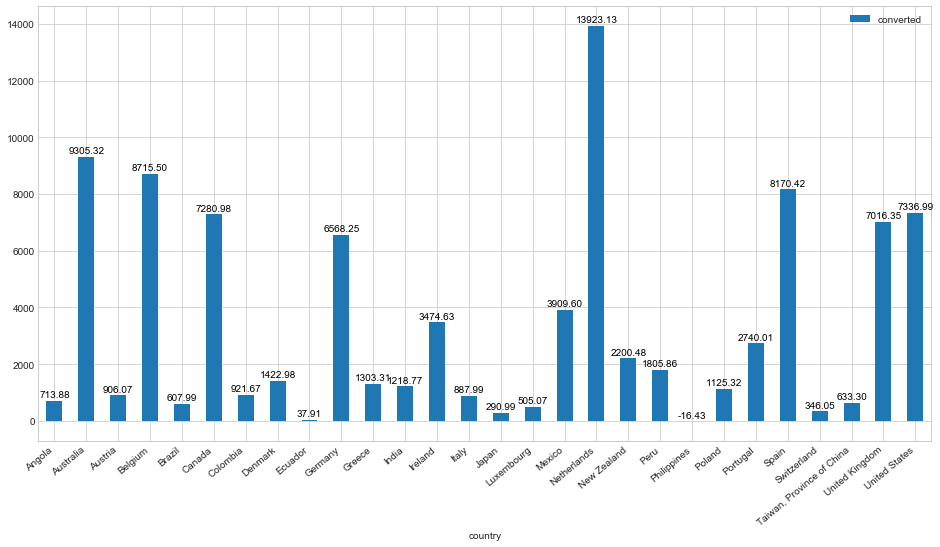

In [8]:
pa=df_country[["converted"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=10, color="black", xytext=(0, 6),
                 textcoords="offset points")

Available variables Campaign Level:
    
    Categorical:
    -name
    -business_name
    -manager_name
    -ad_set_manager_id
    -client
    -notification_stop_spend
    -revenue_multiplier
    -currency
    -country
    -vertical
    
    Continuous:
    -leads
    -revenue
    -margin
    -cpc
    -cpm
    -cpa
    -clicks
    -views
    
    %:
    -marginP
    -ctr
    -cr

______

# 2. Performance per Marketer

### 2.1 Margin % of marketer's campaigns 

#### *option 1: swarmplot*

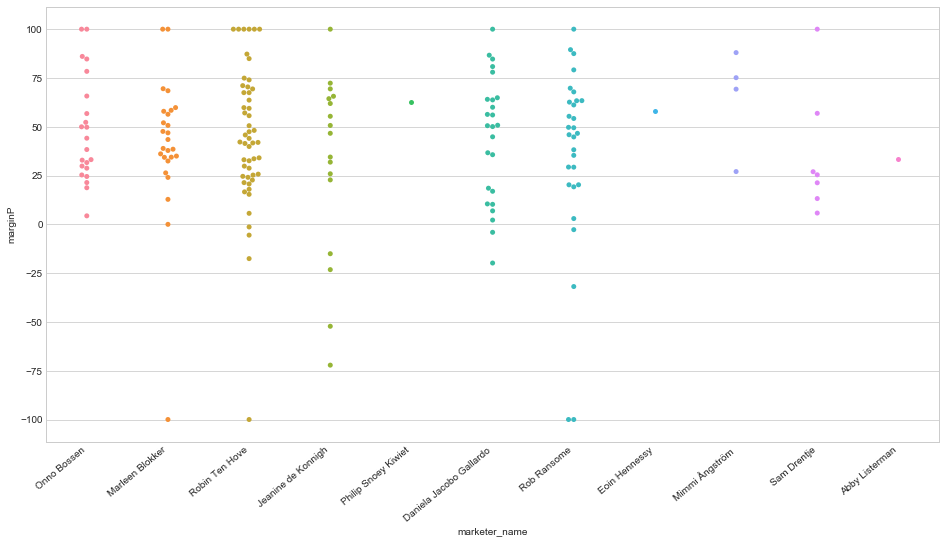

In [9]:
plt.pyplot.figure(figsize=(16,8))
ka=sns.swarmplot(x="marketer_name", y="marginP", data=df_campaign.loc[df_campaign["marginP"]>=-100])
ka.set_xticklabels(ka.get_xticklabels(), rotation=40, ha="right")
ka

#### *option 2: violin plot*

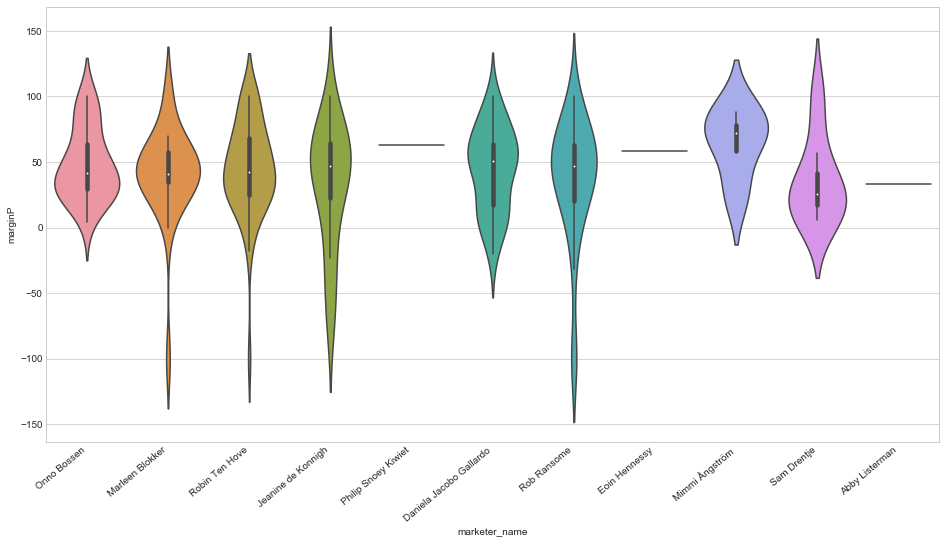

In [10]:
plt.pyplot.figure(figsize=(16,8))
ka=sns.violinplot(x="marketer_name", y="marginP", data=df_campaign.loc[df_campaign["marginP"]>=-100])
ka.set_xticklabels(ka.get_xticklabels(), rotation=40, ha="right")
ka

#### *option 3: individual visualisations (maybe top/bottom 10 campaigns?)*
This is the top 10 highest margins (for Onno in this case) of the week and their margin % 

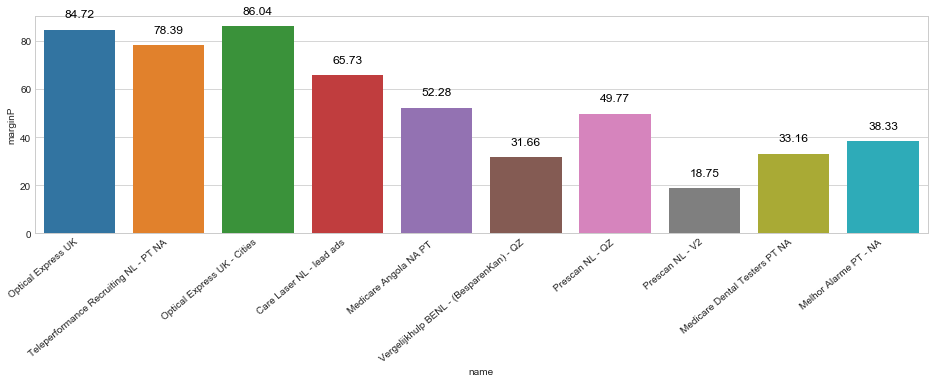

In [11]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_campaign.loc[df_campaign["marketer_name"]=="Onno Bossen"].nlargest(10,'margin'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

In [12]:
#total by marketer
df_marketer=df_campaign.groupby(by=['marketer_name']).sum()

### 2.2 Margin made per Marketer (in Euro)

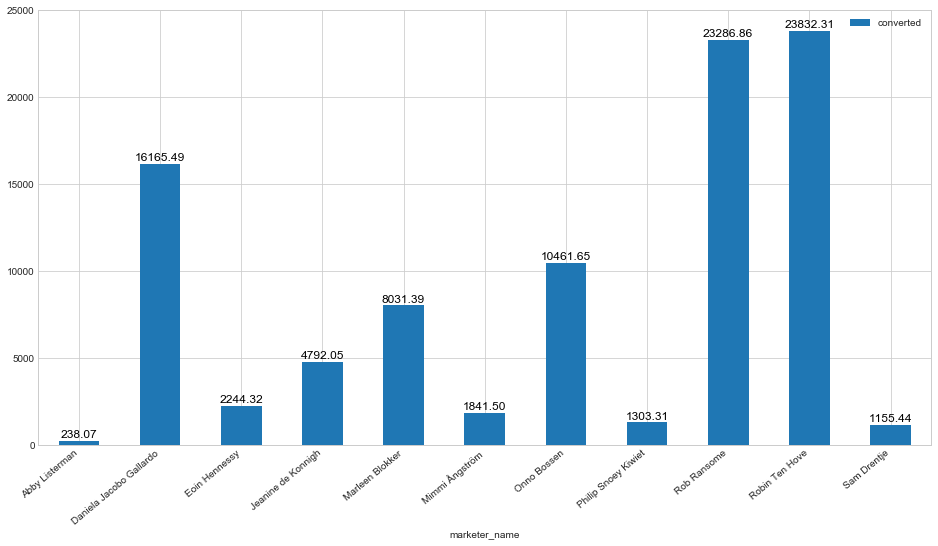

In [13]:
pa=df_marketer[["converted"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.3 Average margin per marketer

In [14]:
#creating new variable
df_marketer["average"]=df_marketer["converted"]/df_marketer["total"]

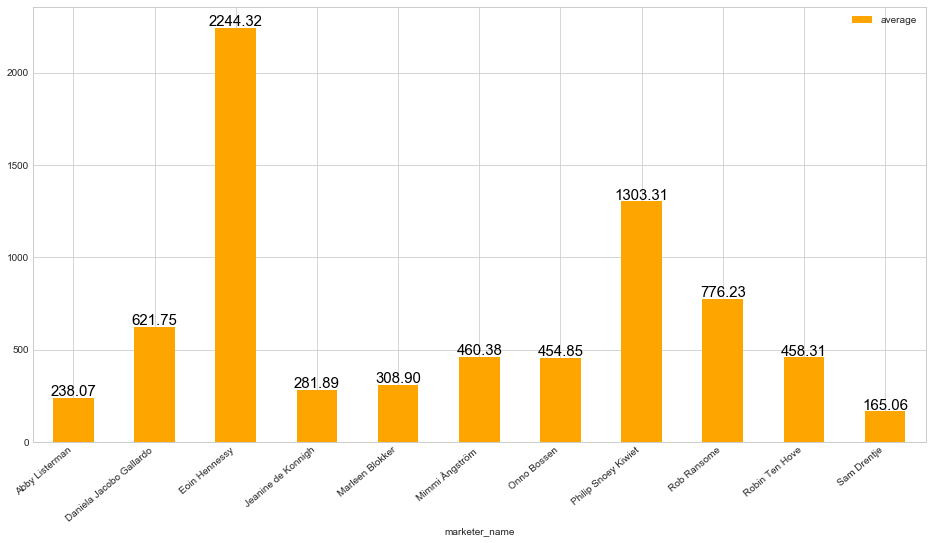

In [15]:
pa=df_marketer[["average"]].plot(kind="bar", figsize=(16,8), color="orange")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.4 Average margin % per marketer

In [16]:
#creating new variable
df_marketer["average_%"]=df_marketer["marginP"]/df_marketer["total"]

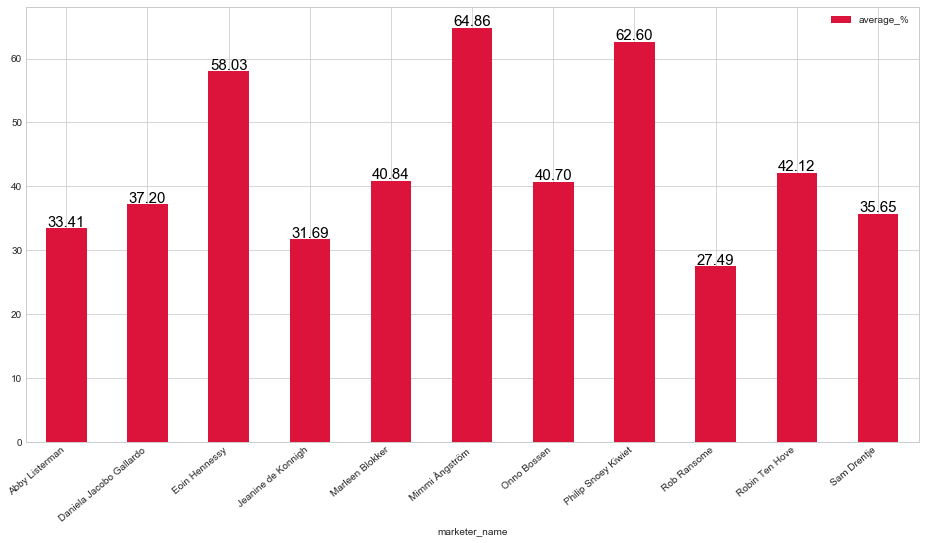

In [17]:
pa=df_marketer[["average_%"]].plot(kind="bar", figsize=(16,8), color="crimson")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

________

# 3. Performance per Vertical

In [18]:
def yoo(x):
    if x["marketer_name"]=="Onno Bossen" or x["marketer_name"]=="Jeanine de Konnigh":
        return("other?")
    if x["marketer_name"]=="Mimmi Ångström" or x["marketer_name"]=="Abby Listerman" or x["marketer_name"]=="Sam Drentje" or x["marketer_name"]=="Marleen Blokker" or x["marketer_name"]=="Daniela Jacobo Gallardo" or x["marketer_name"]=="Daphne Kok":
        return("NGOs")
    if x["marketer_name"]=="Philip Snoey Kiwiet" or x["marketer_name"]=="Robin Ten Hove" or x["marketer_name"]=="Rob Ransome" or x["marketer_name"]=="Eoin Hennessy":
        return("hearing aids")
df_campaign["vertical"] = df_campaign.apply(yoo, axis=1)

### 3.1 Average Margin % per vertical

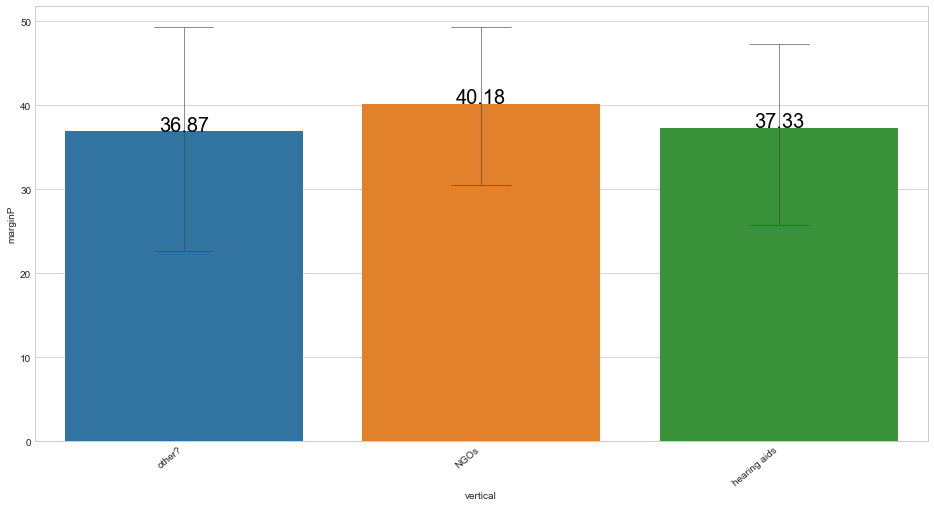

In [19]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="vertical", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [20]:
#total by vertical
df_vertical=df_campaign.groupby(by=['vertical']).sum()
df_vertical["margin_%"]=(df_vertical["margin"]/df_vertical["revenue"])*100
df_vertical["margin_%"]=df_vertical["margin_%"].round(2)
df_vertical["Vertical"]=df_vertical.index

### 3.2 Total Margin % per vertical

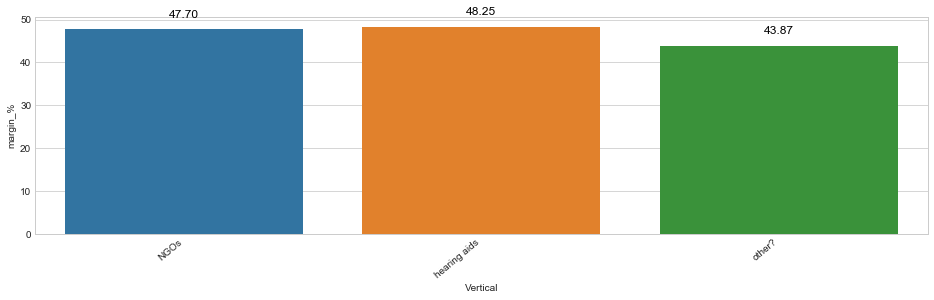

In [21]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="Vertical", y="margin_%", data=df_vertical, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 3.3 Total Margin per vertical

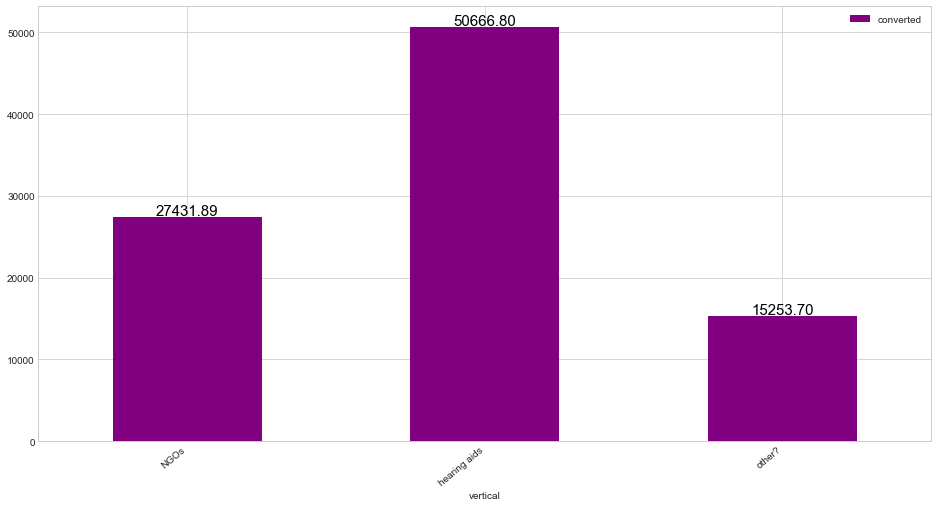

In [22]:
pa=df_vertical[["converted"]].plot(kind="bar", figsize=(16,8), color="purple")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

_______

# 4. Performance per Business

### 4.1 Average Margin % per vertical

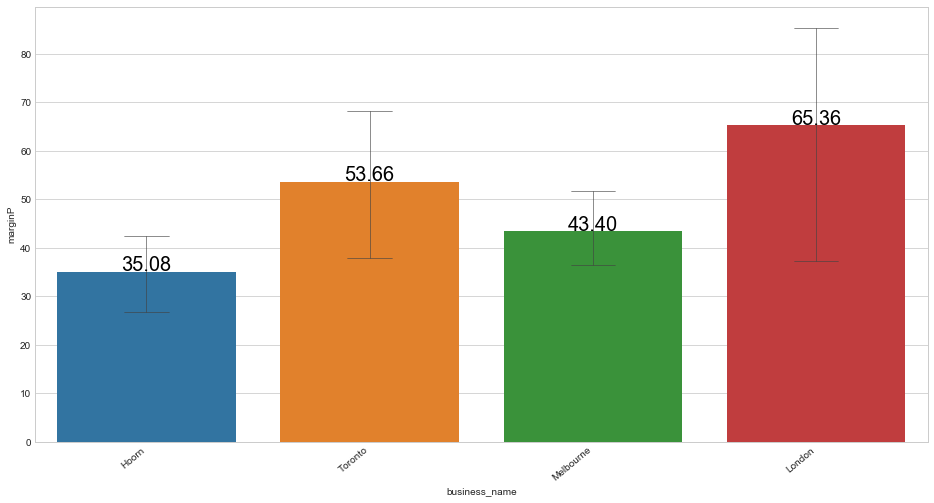

In [23]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="business_name", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [24]:
#total by business
df_business=df_campaign.groupby(by=['business_name']).sum()
df_business["margin_%"]=(df_business["margin"]/df_business["revenue"])*100
df_business["margin_%"]=df_business["margin_%"].round(2)
df_business["Business"]=df_business.index

### 4.2 Total Margin % per vertical

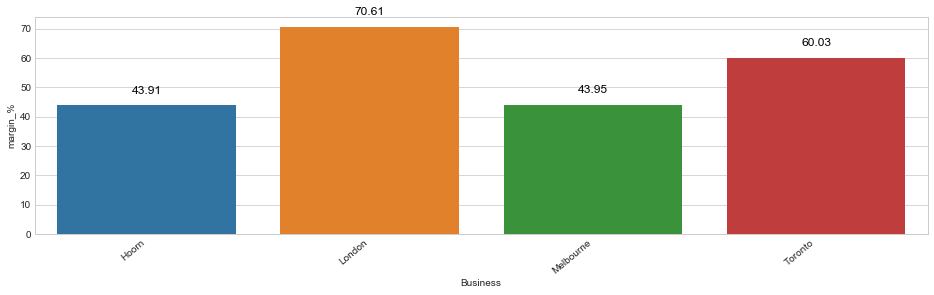

In [25]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="Business", y="margin_%", data=df_business, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 4.3 Margin per Business (in Euro)

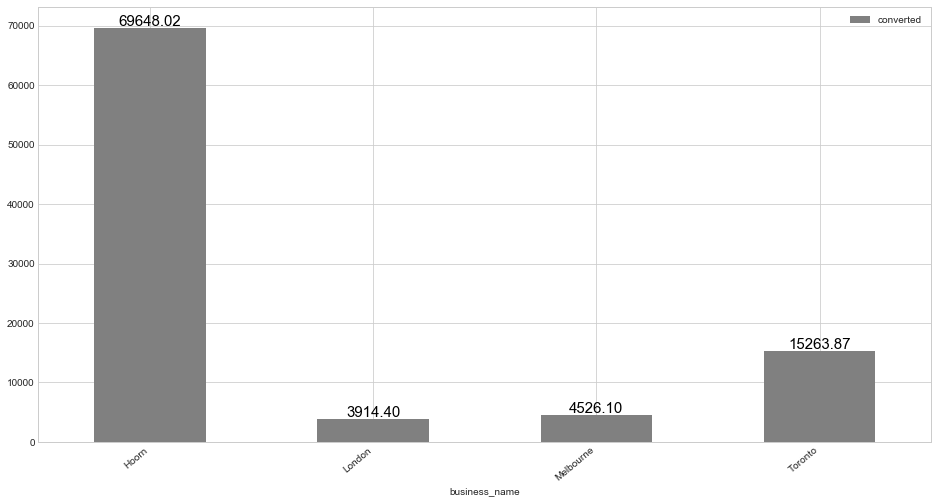

In [26]:
pa=df_business[["converted"]].plot(kind="bar", figsize=(16,8), color="grey")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

___________

# 5. Performance per Day of the Week

CPC, CTR, CPM, CR and CPA are displayed as the average per day

In [27]:
#importing multiple files using glob
#getting bert data
sheetnames=glob.glob("25__*.xlsx")
list_of_dfs = [pd.read_excel(sheet) for sheet in sheetnames]
for dataframe, sheet in zip(list_of_dfs, sheetnames):
    dataframe["day_num"] = sheet
df_daily = pd.concat(list_of_dfs, ignore_index=True) 

In [28]:
### Cleaning

#creating day of the week variable
df_daily["day_num"]=df_daily["day_num"].str.split("_").str[2]
def doo(x):
    if x["day_num"] == "1.xlsx":
        return("monday")
    if x["day_num"] == "2.xlsx":
        return("tuesday")
    if x["day_num"] == "3.xlsx":
        return("wednesday")
    if x["day_num"] == "4.xlsx":
        return("thursday")
    if x["day_num"] == "5.xlsx":
        return("friday")
    if x["day_num"] == "6.xlsx":
        return("saturday")
    else:
        return("sunday")
df_daily["day"] = df_daily.apply(doo, axis=1)

#dropping unused columns
df_daily.drop(columns=["id","status","ad_set_manager_id","client_id","ap_campaign_id","ad_set_campaign_group_id",
                      "notification_stop_spend","notification_stop_spend_threshold","margin_percentage",
                      "facebook_business_id","url","contract_range","salesforce_oppurtunity_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_daily["marginP"] = df_daily.apply(woo, axis=1)
df_daily["marginP"] = df_daily["marginP"].round(2)

#2. COUNTRY NAMES
df_daily["country"]=df_daily["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_daily["country"] = df_daily["country"].apply(get_country_code)
df_daily.drop(columns=["iso_code"], inplace=True)

df_daily.drop(columns=["day_num"], inplace=True)

order=["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]

Available variables Weekly Level:
    
    Categorical:
    -name
    -business_name
    -manager_name
    -client
    -revenue_multiplier
    -currency
    -day
    -country
    
    Continuous:
    -leads
    -revenue
    -purchase
    -margin
    -cpc
    -cpm
    -cpa
    -clicks
    -views
    
    %:
    -rejection rate
    -marginP
    -ctr
    -cr

### 5.1 Average Margin % per day of the Week

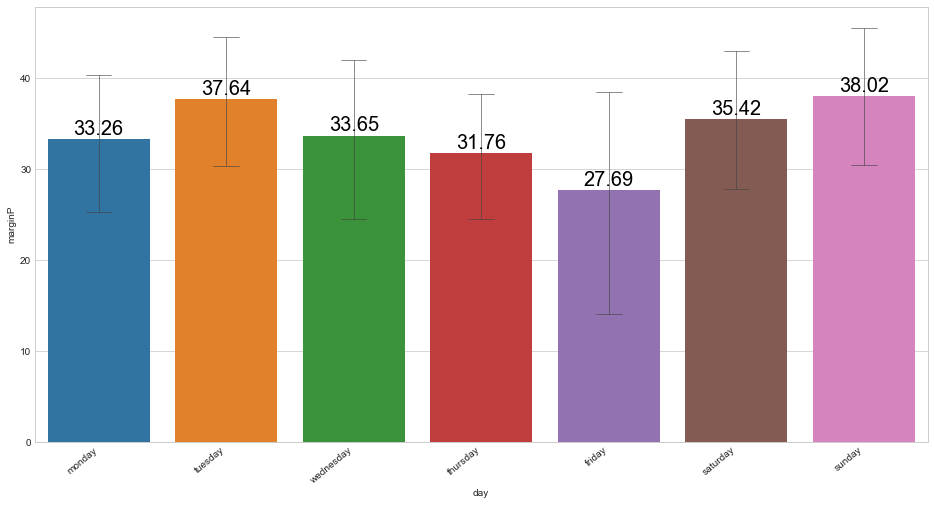

In [29]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="day", y="marginP", data=df_daily, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

In [30]:
df_daily=df_daily.assign(**{"converted": df_daily.apply(converter, axis=1)})

df_daily["converted"]=df_daily["converted"].round(2)

In [31]:
#total by vertical
df_daily_group=df_daily.groupby(by=["day"]).sum()
df_daily_group["margin_%"]=(df_daily_group["margin"]/df_daily_group["revenue"])*100
df_daily_group["margin_%"]=df_daily_group["margin_%"].round(2)
df_daily_group["Day"]=df_daily_group.index

### 5.2 Total Margin % per day

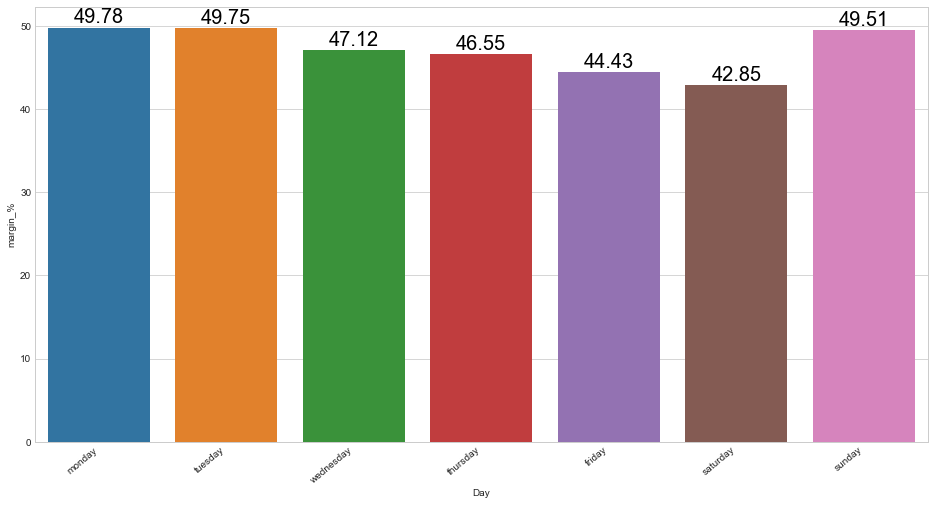

In [32]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="Day", y="margin_%", data=df_daily_group, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

### 5.3 Total Margin

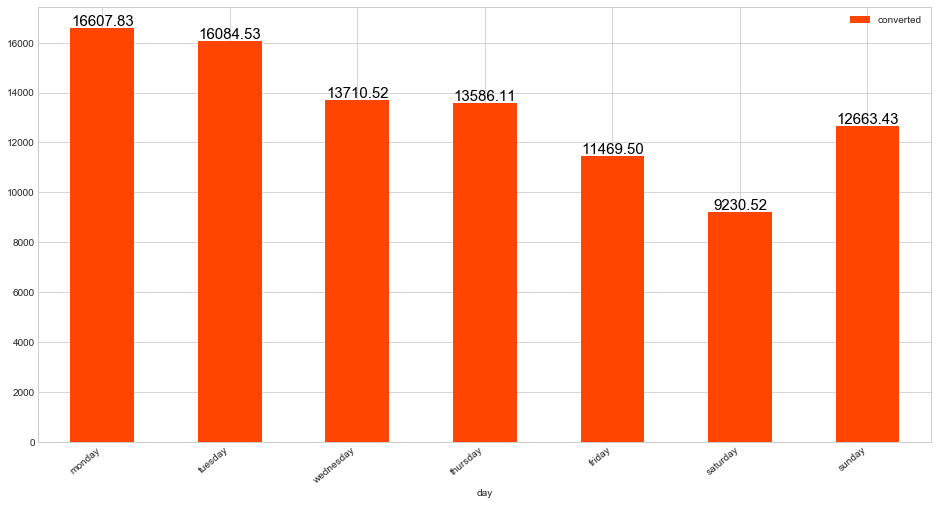

In [33]:
pa=df_daily_group[["converted"]].loc[order].plot(kind="bar", figsize=(16,8), color="orangered")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 5.4 CPA

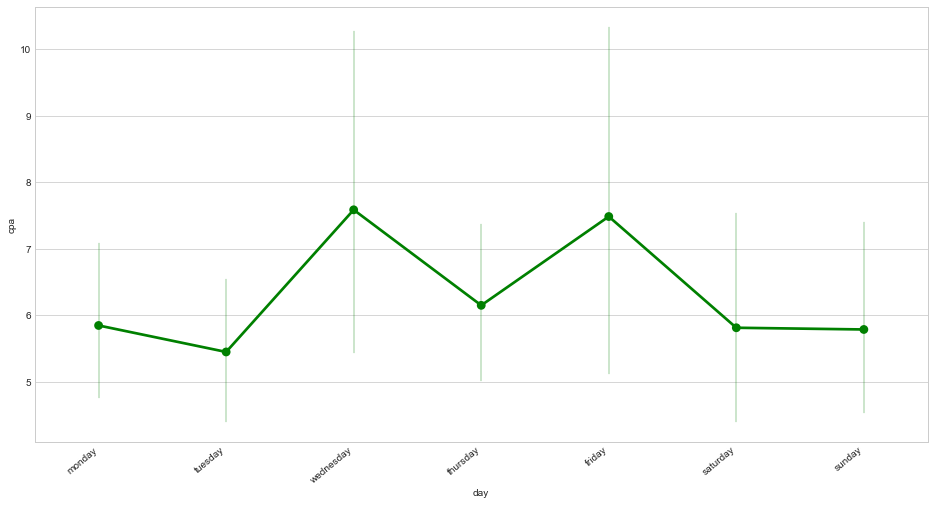

In [34]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpa", data=df_daily, order=order, color="g", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.5 CPC

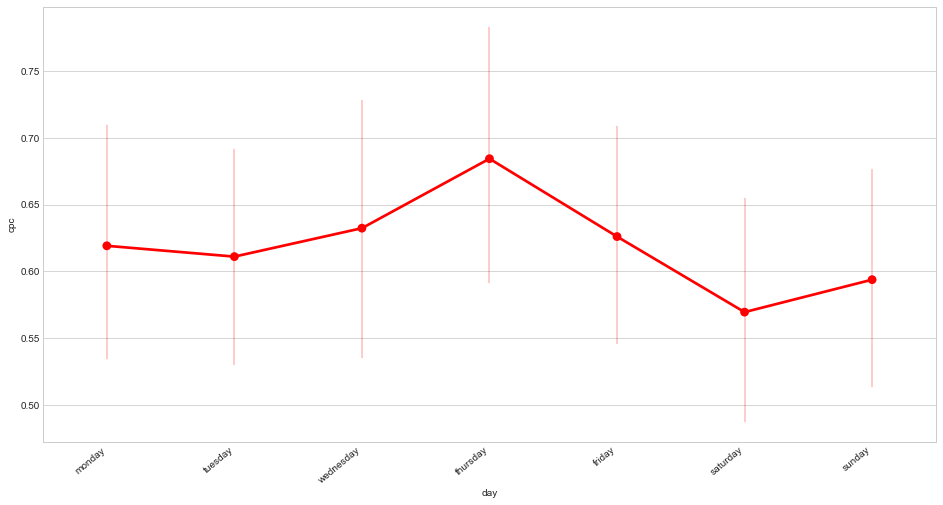

In [35]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpc", data=df_daily, order=order, color="r", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.6 CPM

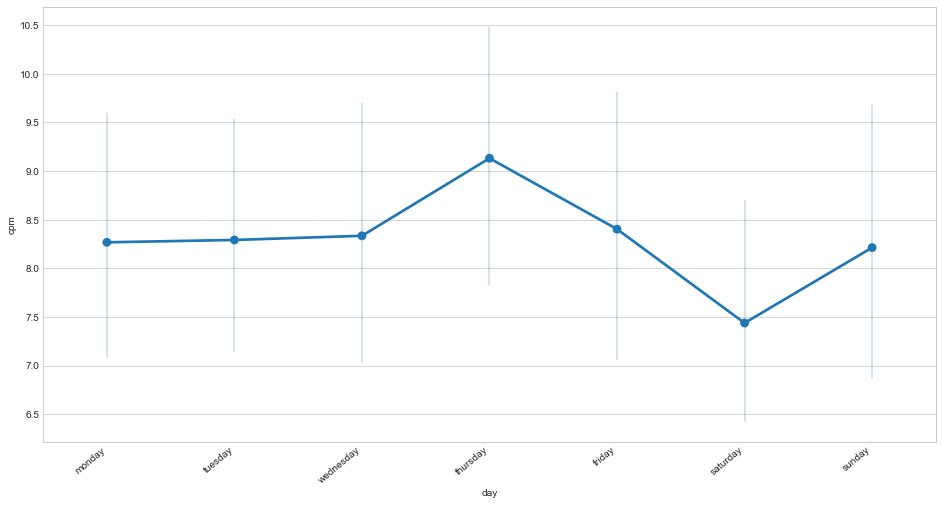

In [36]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpm", data=df_daily, order=order, dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.7 CR

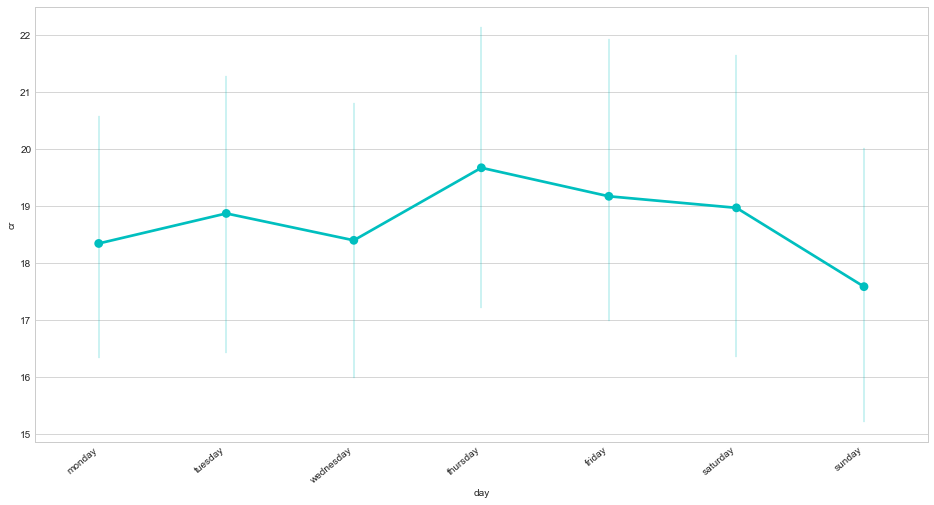

In [37]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.8 CTR

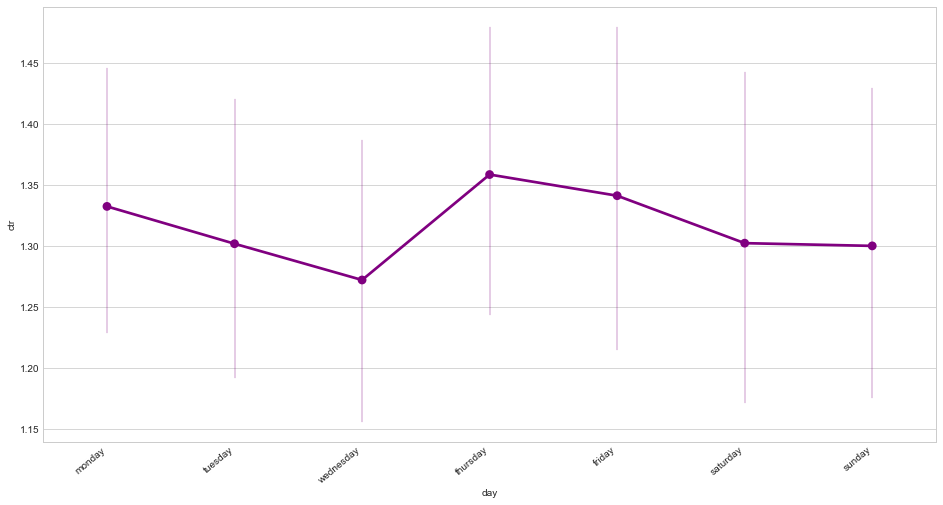

In [38]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="ctr", data=df_daily, order=order, color="purple", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

_______

# 6. Top performing new ads

In [39]:
##### Cleaning

df_raw=pd.read_excel("25_newads.xlsx")

#subsetting data
df_newads=df_raw.loc[df_raw["insert_time"]>=datetime(2018,6,11)]

#dropping columns
df_newads.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                       "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                       "short_url","ad_url_domain_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_newads["marginP"] = df_newads.apply(woo, axis=1)
df_newads["marginP"] = df_newads["marginP"].round(2)

Available variables new ads:
    
    Categorical:
    -tag
    -campaign_name
    -name
    -budget
    -relevance_score (?)
    -insert_time
    -revenue_type
    -currency
    -day
    -country
    
    Continuous:
    -leads
    -revenue
    -purchase
    -margin
    -cpc
    -cpm
    -cpa
    -frequency
    -clicks
    -views
    
    %:
    -rejection rate
    -marginP
    -ctr
    -cr

Potential questions/points for dataframes:

- What relevant variables do we want to see? What columns are important to look at? I have excluded a few below.
- How many values do we want displayed? 10, 20, 30..
- Do we want more 'short' dataframes? e.g. display the top 5 in margin, leads, cr, cpc etc
- It could be interesting to look at budgets here. Since these ads were only added during the week, it is likely (but not guaranteed) that the budgets were not changed



The table below shows new ads that had a margin % above 50%. They are displayed in descending order from highest margin to lowest (this will filter out ads with 100% margins that made very little money). 



In [40]:
df_newads.loc[df_newads['marginP']>=50].nlargest(10,'margin').drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,marketer_name,campaign_manager_name,account_manager_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,update_time,currency,marginP,views,clicks
1861,SB000000001155944,Optical Express UK,Onno Bossen,Aedan Toal,Matt Butcher,30.0,73,992.80,137.37,855.43,1.0,0.4,3.9,21.2,1.9,2018-06-27 02:00:14,GBP,86.16,35496,344
1626,SB000000001155542,Bloom Hearing UK - beyond - RSP v2,Rob Ransome,Marisa Jimenez,Sander Janssen,60.0,42,1096.20,244.20,852.00,1.4,1.0,13.9,17.4,5.8,2018-06-26 04:03:08,EUR,77.72,17609,242
1660,SB000000001155767,HelloFresh BENL - Kookenquête Nespresso,Robin Ten Hove,Eveline Morlang,Bart Kramer,50.0,461,1037.25,301.58,735.67,1.0,0.2,2.1,32.4,0.7,2018-06-25 01:14:05,EUR,70.93,141839,1425
1862,SB000000001155953,Optical Express UK,Onno Bossen,Aedan Toal,Matt Butcher,30.0,57,775.20,134.89,640.31,1.0,0.4,3.8,16.9,2.4,2018-06-27 02:00:20,GBP,82.60,35213,337
1725,SB000000001154666,Miracle Ear Genius 3.0,Robin Ten Hove,Daniela Salom Cardenas,Sen Nathan,100.0,41,1168.50,545.62,622.88,0.9,3.6,32.4,27.2,13.3,2018-06-27 08:01:55,CAD,53.31,16851,151
1480,SB000000001154201,Connect Hearing CA,Rob Ransome,Daniela Salom Cardenas,Sen Nathan,120.0,23,772.80,195.15,577.65,1.7,1.3,22.3,15.8,8.5,2018-06-27 10:01:39,CAD,74.75,8758,146
1694,SB000000001156097,HelloFresh NL - Food Festival Quiz,Robin Ten Hove,Eveline Morlang,Bart Kramer,75.0,311,839.70,308.37,531.33,1.4,0.3,4.4,32.0,1.0,2018-06-27 01:11:37,EUR,63.28,69752,973
1513,SB000000001152935,Save the Children Australia,Marleen Blokker,Tom Wells,Suzie Squire,75.0,165,792.00,324.70,467.30,3.7,0.7,24.7,33.5,2.0,2018-06-26 10:40:57,AUD,59.00,13151,492
1933,SB000000001157291,Teleperformance Recruiting NL - PT NA,Onno Bossen,Sjoerd Knol,Bart Kramer,30.0,31,558.00,95.86,462.14,1.1,0.4,4.4,13.0,3.1,2018-06-22 14:44:00,EUR,82.82,21616,239
1422,SB000000001153163,WWF Germany - Against Coal,Daniela Jacobo Gallardo,Jordy Schreuder,Othman Namri,30.0,436,610.40,186.99,423.41,2.7,0.2,4.2,36.6,0.4,2018-06-24 20:17:59,EUR,69.37,44833,1192


.


e.g. this shows the top 10 margin (percentage) ads that had margins of over €150, ordered from highest conversion rate to lowest conversion rate.


In [41]:
df_newads.loc[df_newads['margin']>=150].nlargest(10,'marginP').sort_values(by='cr', ascending=False).drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,marketer_name,campaign_manager_name,account_manager_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,update_time,currency,marginP,views,clicks
2073,SB000000001158266,Ayuda en Acción Colombia - lead ads,Daniela Jacobo Gallardo,Theun Sijm,Maider Sánchez Elizondo,10.0,88,190.08,26.19,163.89,1.3,0.1,1.1,29.3,0.3,2018-06-26 08:03:15,EUR,86.22,23442,300
1864,SB000000001155986,Optical Express UK - Cities,Onno Bossen,Aedan Toal,Matt Butcher,5.0,16,217.60,23.11,194.49,1.5,0.3,5.3,23.9,1.4,2018-06-27 02:00:29,GBP,89.38,4394,67
1871,SB000000001156025,Optical Express UK - Cities,Onno Bossen,Aedan Toal,Matt Butcher,5.0,16,217.60,23.36,194.24,1.5,0.3,5.2,23.2,1.5,2018-06-27 02:01:00,GBP,89.26,4457,69
1861,SB000000001155944,Optical Express UK,Onno Bossen,Aedan Toal,Matt Butcher,30.0,73,992.80,137.37,855.43,1.0,0.4,3.9,21.2,1.9,2018-06-27 02:00:14,GBP,86.16,35496,344
1863,SB000000001155968,Optical Express UK - Cities,Onno Bossen,Aedan Toal,Matt Butcher,5.0,13,176.80,22.76,154.04,1.4,0.4,5.1,21.0,1.8,2018-06-27 02:00:24,GBP,87.13,4496,62
1866,SB000000001155995,Optical Express UK - Cities,Onno Bossen,Aedan Toal,Matt Butcher,5.0,15,204.00,24.07,179.93,1.7,0.3,5.2,19.0,1.6,2018-06-27 02:00:37,GBP,88.20,4623,79
1862,SB000000001155953,Optical Express UK,Onno Bossen,Aedan Toal,Matt Butcher,30.0,57,775.20,134.89,640.31,1.0,0.4,3.8,16.9,2.4,2018-06-27 02:00:20,GBP,82.60,35213,337
1933,SB000000001157291,Teleperformance Recruiting NL - PT NA,Onno Bossen,Sjoerd Knol,Bart Kramer,30.0,31,558.00,95.86,462.14,1.1,0.4,4.4,13.0,3.1,2018-06-22 14:44:00,EUR,82.82,21616,239
1569,SB000000001155149,HelloFresh BENL - Pizza Quiz,Robin Ten Hove,Eveline Morlang,Bart Kramer,30.0,79,177.75,0.00,177.75,0.0,0.0,0.0,0.0,0.0,2018-06-25 01:14:09,EUR,100.00,0,0
1699,SB000000001156169,SOS Children's Villages India - Lead Ads,Mimmi Ångström,Marisa Jimenez,Sander Janssen,8.0,161,205.28,0.00,205.28,0.0,0.0,0.0,0.0,0.0,2018-06-26 16:15:10,EUR,100.00,0,0


______________

# 7. Campaigns that are dropping in margin from 45% + to below 45%

In [42]:
#importing new dataset
df_comp_raw=pd.read_excel("24_newads.xlsx")


####FOR WEEK BEFORE DF####


#dropping columns
df_comp_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                          "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                          "short_url","ad_url_domain_id"], inplace=True)


#1. FIX MARGIN_P
df_comp_raw["marginP"] = df_comp_raw.apply(woo, axis=1)
df_comp_raw["marginP"] = df_comp_raw["marginP"].round(2)



####FOR FULL RAW WEEK#####


#dropping columns
df_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                     "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                     "short_url","ad_url_domain_id"], inplace=True)


#1. FIX MARGIN_P
df_raw["marginP"] = df_raw.apply(woo, axis=1)
df_raw["marginP"] = df_raw["marginP"].round(2)


#####SLIMMING COMB DATA DOWN TO ONLY INCLUDE MARGINS ABOVE 45%###########
df_comp=df_comp_raw.loc[df_comp_raw["marginP"]>=45]

####COMBING DATA SETS########
df_452=df_comp.merge(df_raw, how ="inner", on = ["tag"])

df_45=df_452.loc[df_452["marginP_y"]<45]

The number of ads that dropped below 45%: 

In [43]:
len(df_45)

263

In [44]:
#making difference variable
df_45["diff_mP"]=df_45["marginP_x"]-(df_45["marginP_y"])
df_45["diff_m"]=df_45["margin_x"]-(df_45["margin_y"])

In [45]:
#ordering df for simple comparisons
df_45vis = df_45[["tag","campaign_name_x","name_x","diff_mP","diff_m","marginP_x","marginP_y","margin_x","margin_y","ctr_x",
                  "ctr_y","cpm_x","cpm_y","cr_x","cr_y","cpa_x","cpa_y"]]

These are the 10 ads that lost the largest amount of money between the two weeks (i.e. Week 24 and Week 25). 
Here we can compare the other variables a bit easier as well.

_x = week 24

_y = week 25

diff_mP = Difference in Margin % between Week 25 and Week 24 .  
diff_m = Difference in Margin between Week 25 and Week 24 .   

In [46]:
df_45vis.nlargest(10,"diff_m")#.sort_values(by='diff_m', ascending=False)

,tag,campaign_name_x,name_x,diff_mP,diff_m,marginP_x,marginP_y,margin_x,margin_y,ctr_x,ctr_y,cpm_x,cpm_y,cr_x,cr_y,cpa_x,cpa_y
610,SB000000001152476,HelloFresh BEFR - Pizza Quiz,T 6 V SB May3 AP M/F 23+ ALL,28.41,629.62,48.67,20.26,756.96,127.34,1.4,1.0,5.1,4.9,29.9,26.4,1.2,1.8
237,SB000000001141199,Belsono - Hearing Health Free Evaluation,T1 I SB April C M/F 50+ ALL,12.12,488.09,48.36,36.24,1033.47,545.38,1.7,1.5,22.9,22.3,8.9,7.6,15.5,19.2
224,SB000000001140971,Vitakustik IIC,T Mei DESIGN V1 M/F 50+ ALL,34.39,447.90,46.82,12.43,547.12,99.22,0.5,0.5,5.5,7.0,7.7,6.1,15.2,25.0
648,SB000000001152851,Make A Wish Australia,T JUNE18 2 I JUNE18 Kael 1 MV 25+ ALL - New CT...,32.02,414.45,47.50,15.48,487.95,73.50,1.6,1.3,12.2,13.6,30.5,25.5,2.5,4.1
343,SB000000001141349,SayWhat Clinics,T18 I A M/V 50+ ALL LAL,29.74,340.38,58.03,28.29,469.85,129.47,2.5,2.5,43.5,43.2,11.9,7.0,14.8,25.2
65,SB000000001117439,Compare & Connect - E-Bike AU UD,T 2 I 14 – MV 25+ MD,78.96,331.03,63.39,-15.57,320.85,-10.18,0.3,0.3,1.5,1.6,17.5,6.5,2.7,8.4
355,SB000000001143533,Miracle Ear Genius 3.0,T1 I SB May1 D M/F 50+ M/D - LAL 5%,17.66,256.94,53.31,35.65,358.55,101.61,0.9,0.9,26.3,22.7,20.7,13.7,13.7,18.3
192,SB000000001139018,The Heart Research Institute - Lead Ads,T1 I MAY18 8 V 21+ ALL,19.14,238.01,53.33,34.19,264.75,26.74,4.6,3.8,14.5,13.1,19.9,15.5,1.6,2.2
510,SB000000001149464,Akoustica Medica,T1 I M M/V 50+ D/M,30.81,229.63,66.88,36.07,299.60,69.97,0.9,0.8,3.4,3.5,7.6,4.3,5.3,10.3
552,SB000000001150997,Blackberry Hearing,T4 istock C M/V 50+ M/D,22.75,223.57,50.76,28.01,485.44,261.87,0.8,0.8,2.9,3.4,3.5,2.7,10.5,15.3


In [47]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

______